# Explore here

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pickle import dump

In [2]:
URL = r'https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv'
df = pd.read_csv(URL)

# Data overview

In [3]:
df.date = df.date.astype('datetime64[ns]')
df.set_index('date', drop=True, inplace=True)
df

,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633
...,...
2023-08-30 17:10:08.079328,989.600354
2023-08-31 17:10:08.079328,994.987326
2023-09-01 17:10:08.079328,995.814415


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2022-09-03 17:10:08.079328 to 2023-09-03 17:10:08.079328
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


## Data overview conclusions.

Our data is very simple in this case, just the date and a sales number. Also is pretty clean, there are no missing values.

# Time series analysis

Usually we would do a full EDA but since our data is in time series format we need to do an special analysis.

## Decomposition analysis

we will look first at the seasonal decomposition of the series. This means that we will extract from the original series the overall trend, the seasonal component (part of the series that looks like it's having a patter over time) and a residual term that tells us how good this two terms decompose the series.

In [5]:
decomposition = seasonal_decompose(df)

### figure 1.

Trend and sales plot. 

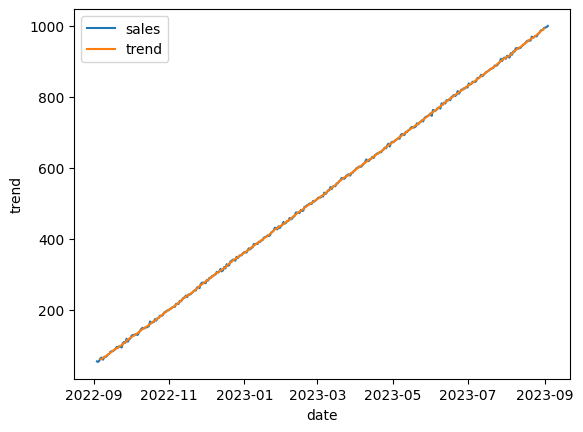

In [6]:
sns.lineplot(df)
sns.lineplot(decomposition.trend, label='trend')
plt.legend()
plt.show()

### figure 2.

Seasonal component and residual plot

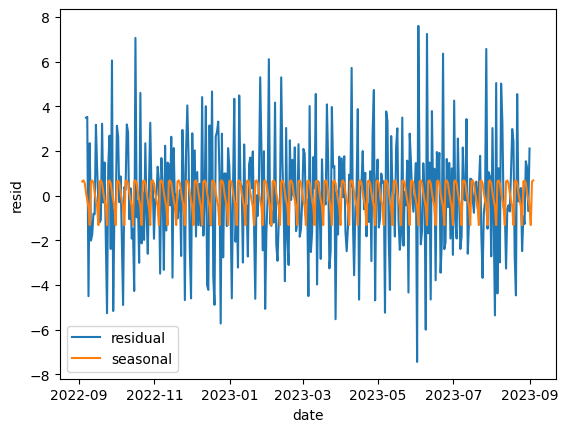

In [7]:
sns.lineplot(decomposition.resid, label='residual')
sns.lineplot(decomposition.seasonal, label='seasonal')
plt.legend()
plt.show()

### figure 3.
Autocorrelation

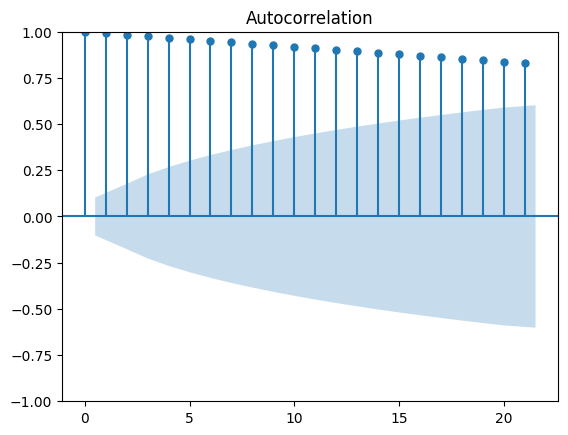

In [ ]:
plot_acf(df,lags=21)
plt.show()

## Stationary analysis

Next, we will use an statistical test to find if the data is stationary.

In [14]:
pvalue = adfuller(df, autolag='BIC')[1]

print(f'Original series p-value: {pvalue}')

Original series p-value: 0.9840622176083867


In [15]:
stationary_df = df.diff().dropna()
pvalue_diff = adfuller(stationary_df, autolag='BIC')[1]
print(f'Differentiated series p-value: {pvalue_diff}')

Differentiated series p-value: 2.519218008032526e-26


### stationary analysis conclusion.

Our original time series is non-stationary which to be hones was a bit obvious (the mean increases over time), but differenciating one time is enough to make it stationary.

## Time series analysis conclusions

- Our time series is fairly simple since our tensor is 1-dimensional (the sales number).
- In our case the trend is clear and predictable since our data resembles a linear plot with positive slope.
- Even though the autocorrelation graph does not show it clearly (because the variations ar too small compared to the scale of our data), there is seasonality in our series, but we would need some further analysis to determine reliably determine what is the period of our data.
- Also the series are not stationary but can become if we differentiate once.
- There is some noise that can't be predicted seasonally, so it shows up in the residual plot (fig 2)

# Model creation

Given our analysis and the fact that we only have one feature, looks like an ARIMA model could be a good option for this problem. Given that there is needed more analysis needed for determining the seasonal period, it would make sense to use the `auto_arima` model from `pmdarima`. 

In [27]:
train, test = train_test_split(df, test_size=0.2, shuffle=False)
warnings.filterwarnings('ignore')

In [ ]:
model = auto_arima(train, seasonal = True, trace = True, d=1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1675.428, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1578.564, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1475.165, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1763.761, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1475.512, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1475.495, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1479.028, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1762.924, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.268 seconds


## Model metrics measurement

In [29]:
ypred = model.predict(74)
r2 = r2_score(test, ypred)
mse = mean_squared_error(test, ypred)

print(f'r\u00b2 score: {r2:.3}')
print(f'mean squared error: {mse:.3}')

r² score: 0.997
mean squared error: 7.82


### figure 4.

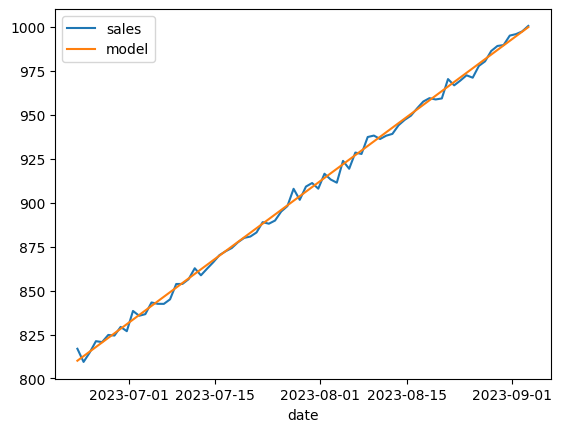

In [22]:
warnings.resetwarnings()
sns.lineplot(test)
sns.lineplot(ypred, label='model')
plt.show()

## Model analysis
- We got a very good prediction, we can see that from our graph (fig 4) and our $r^2$ (close to 1) and mean squared error (7 is fairly small for numbers around 900). so we can conclude that the ARIMA model was a good choice.

## Saving the model

In [31]:
path = '../models/' + 'time_series_arima_p0_m1_d1)' + '.sav'
dump(model, open(path, 'wb'))